# Data Analysis And Model Preparation For Stone-Paper-Scissor
    -> Stone-Paper-Scissor is a web app project which enables users to play the renowned "Stone Paper Scissors" game.
    -> User's movements are captured using the camera, and get classified into one of the three classes.

### Data Collection
    -> Samples were collected manually using Mediapipe(an open source framework by Google for media processing).
    -> Webcam was used to get frames for the three classes, and then the features(coordinates) were extracted using Mediapipe.

### About Data
    -> Each Sample in the dataset consists of 21 key points for hand recognition
    -> Each keypoint represented by it's corresponding x and y coordinates.
    -> So, the input contains 21*2 = 42 different features.
    -> The dataset used contains around 45k examples.
    -> Each example represents either "Stone", "Paper" or "Scissor".

In [1]:
# Importing necessary dependencies

import numpy as np
import pandas as pd
import cv2
import os
import h5py
import matplotlib.pyplot as plt
from skimage import feature
import seaborn as sns
import math
from datetime import datetime
import sklearn
import joblib


from sklearn.model_selection import KFold, RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer

In [2]:
# loading dataset
data = pd.read_csv('../input/stone-paper-scissors-hand-landmarks-dataset/data.csv')

In [3]:
data.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,Category
0,0.620448,0.616574,0.590011,0.537064,0.577106,0.442460,0.574392,0.358051,0.555631,0.297962,...,0.320809,0.710040,0.527919,0.759093,0.461097,0.791235,0.425651,0.817787,0.391883,Paper
1,0.793385,0.601346,0.759365,0.550227,0.748562,0.505328,0.731791,0.478341,0.720204,0.463190,...,0.500592,0.794161,0.496951,0.739818,0.491090,0.734723,0.512681,0.744312,0.524284,Scissor
2,0.569872,0.368590,0.619827,0.360140,0.659398,0.314017,0.660076,0.254015,0.634577,0.216759,...,0.301853,0.557915,0.232007,0.596949,0.229729,0.597537,0.268840,0.584087,0.282801,Stone
3,0.321641,0.613728,0.361642,0.560630,0.380633,0.514779,0.393544,0.493892,0.400883,0.494755,...,0.519609,0.310169,0.524453,0.365341,0.517301,0.385874,0.518706,0.392552,0.515370,Scissor
4,0.767176,0.946333,0.773455,0.867742,0.766660,0.783190,0.750389,0.717175,0.748243,0.663134,...,0.778219,0.668358,0.910875,0.616880,0.892322,0.583505,0.882723,0.554441,0.872217,Paper


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45050 entries, 0 to 45049
Data columns (total 43 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0_x       45050 non-null  float64
 1   0_y       45050 non-null  float64
 2   1_x       45050 non-null  float64
 3   1_y       45050 non-null  float64
 4   2_x       45050 non-null  float64
 5   2_y       45050 non-null  float64
 6   3_x       45050 non-null  float64
 7   3_y       45050 non-null  float64
 8   4_x       45050 non-null  float64
 9   4_y       45050 non-null  float64
 10  5_x       45050 non-null  float64
 11  5_y       45050 non-null  float64
 12  6_x       45050 non-null  float64
 13  6_y       45050 non-null  float64
 14  7_x       45050 non-null  float64
 15  7_y       45050 non-null  float64
 16  8_x       45050 non-null  float64
 17  8_y       45050 non-null  float64
 18  9_x       45050 non-null  float64
 19  9_y       45050 non-null  float64
 20  10_x      45050 non-null  fl

In [5]:
data.describe(include = 'all')

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,Category
count,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,...,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050.000000,45050
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paper
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15050
mean,0.518611,0.580234,0.520958,0.545479,0.523531,0.509388,0.525988,0.488295,0.527856,0.479334,...,0.481692,0.518972,0.517853,0.520799,0.506729,0.521346,0.508763,0.521288,0.508146,NaN
std,0.234706,0.216410,0.228548,0.208667,0.227467,0.206545,0.230539,0.211877,0.234065,0.218476,...,0.225473,0.241488,0.222135,0.242948,0.225302,0.243331,0.224676,0.244732,0.226893,NaN
min,-0.121575,-0.054421,-0.060702,-0.033044,-0.042887,0.015470,-0.083954,-0.017472,-0.106092,-0.093882,...,-0.095434,-0.088948,0.018773,-0.143284,-0.013900,-0.167988,-0.042707,-0.176231,-0.067498,NaN
25%,0.322979,0.424290,0.333143,0.389076,0.341697,0.346845,0.345083,0.319492,0.344749,0.307390,...,0.307806,0.319048,0.337034,0.323293,0.325986,0.327235,0.331125,0.327217,0.330808,NaN
50%,0.513519,0.575814,0.513638,0.539129,0.517069,0.505285,0.521624,0.482632,0.520364,0.473339,...,0.484980,0.513972,0.513906,0.515816,0.505316,0.516263,0.505633,0.516815,0.508234,NaN
75%,0.728605,0.756300,0.723517,0.711246,0.723024,0.676821,0.725845,0.665988,0.725642,0.664712,...,0.663899,0.734827,0.703515,0.732905,0.697572,0.731056,0.697995,0.731321,0.696292,NaN


<BarContainer object of 3 artists>

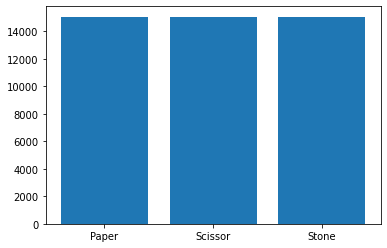

In [6]:
plt.bar(x =data['Category'].value_counts().index, height =  data['Category'].value_counts())

## Visualizing the Dataset

In [7]:
def view_landmarks(landmarks):
    images = []
    for idx in range(len(landmarks)):
        img = np.zeros((256, 256, 3), dtype=np.uint8)
        landmark = landmarks.iloc[idx]
        lms = [(int(landmark[2*i]*256), int(landmark[2*i+1]*256)) for i in range(21)]
        for idx, lm in enumerate(lms):

            # Plot wrist as green
            if(idx == 0):
                img = cv2.circle(img, lm, radius = 1, color = (0, 255, 0), thickness = 2)
            elif(idx % 4 == 0):
                img = cv2.circle(img, lm, radius = 1, color = (255, 0, 0), thickness = 2)
            else:
                img = cv2.circle(img, lm, radius = 1, color = (255, 255, 255), thickness = 2)


        images.append((img, landmark[42]))
    return images

def plot_landmarks(landmarks, name:str = None):
    # Plot 16 landmarks at random
    fig, axes = plt.subplots(3, 3, figsize = (20, 20))
    axarr = axes.flat
    images = view_landmarks(landmarks)

    for i, axis in enumerate(axarr):
        axis.imshow(images[i][0])
        axis.set_title(images[i][1], fontdict = {'family': 'Serif', 'fontsize': 30})
        axis.axis('off')
        axis.set_title
    
    plt.subplots_adjust(
    left=0.1,
    bottom = 0.1,
    right=0.9,
    top = 0.9,
    wspace=0.1,
    hspace = 0.3    
    )
    if name:
        fig.savefig(name)
    


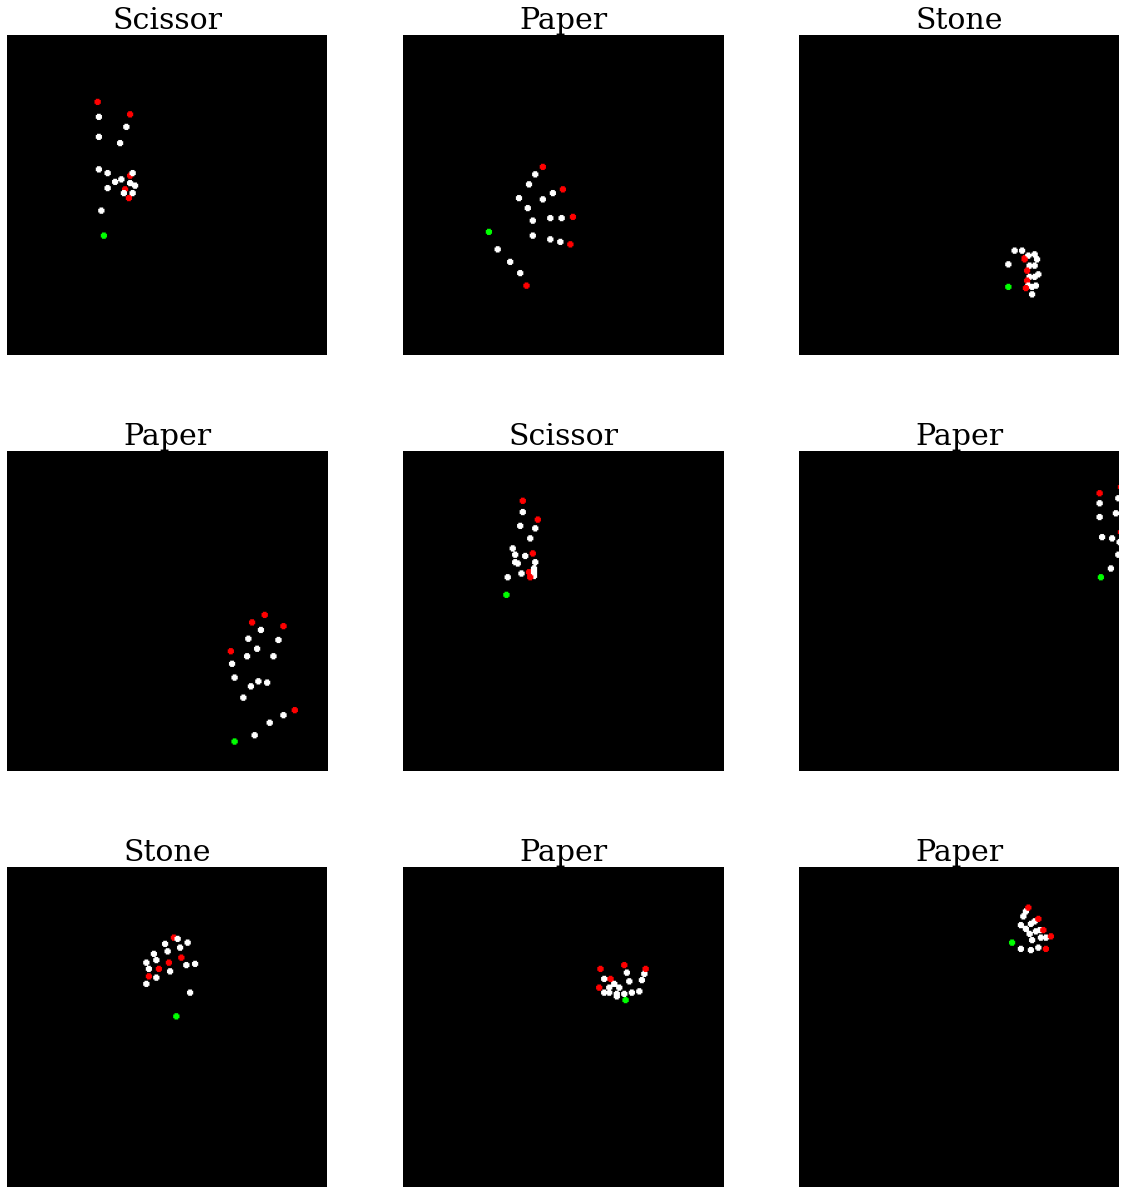

In [8]:
plot_landmarks(data.sample(n = 9), name = "Landmarks_plot.jpeg")
# Green point denotes the wrist, and Red ones denotes the tips of fingers.

In [9]:
encoder = {
    "Stone": 0,
    "Paper": 1,
    "Scissor": 2
}
labels = ["Stone", "Paper", "Scissor"]

# Convert the labels into encoded format
# data['Category'] = [encoder[i] for i in data['Category']]

### Analysis from above plots
    -> We can observe that the plots resemble the pattern similar to their mentioned class.
    -> The plots seem to be localized in a very small area of the images.
    -> Their position on plot has no value our classification.
    -> Rather, we care about the pattern they form together.

## Feature Transformation
    -> All the landmarks of a given example are centerd with respect to the position of wrist.

In [10]:
# Let's first check by relocating the landmarks to center
data.iloc[:, [2*i for i in range(21)]] = data.iloc[:, [2*i for i in range(21)]] - data.iloc[:, [0 for i in range(21)]].values + 0.5
data.iloc[:, [(2*i)+1 for i in range(21)]] = data.iloc[:, [(2*i)+1 for i in range(21)]] - data.iloc[:, [1 for i in range(21)]].values + 0.5

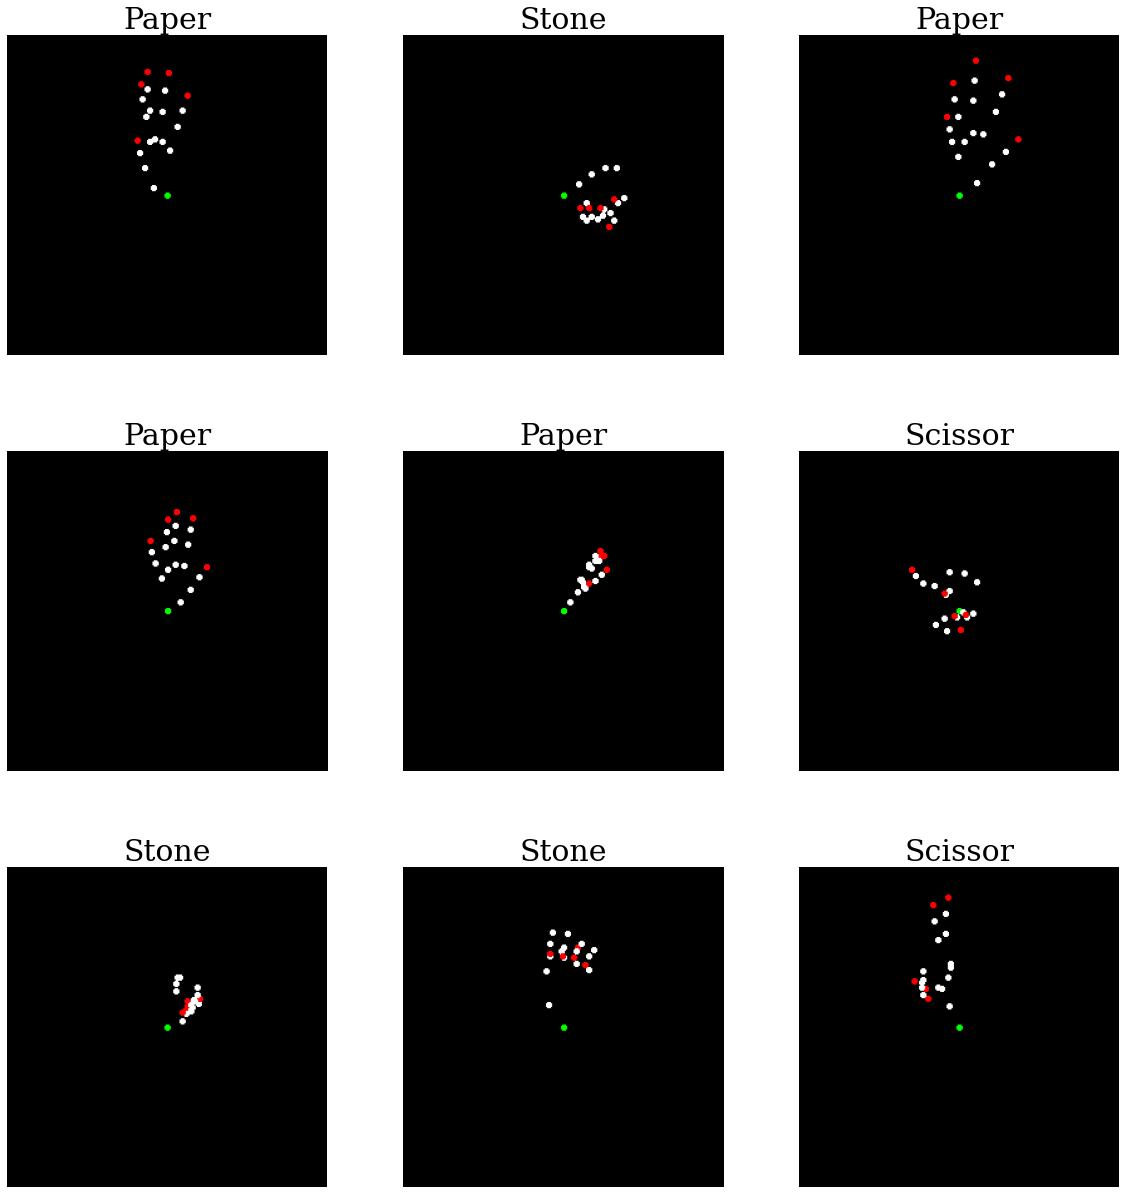

In [11]:
plot_landmarks(data.sample(n = 16), 'centered_lms')

## Observations-
    -> The wrist landmark always lies at center of the plot.
    -> We shall relocate all the landmarks to 0, 0 for better model training.

In [12]:
# Landmarks are relocated wrt wrist
data.iloc[:, [2*i for i in range(21)]] = data.iloc[:, [2*i for i in range(21)]] - data.iloc[:, [0 for i in range(21)]].values
data.iloc[:, [(2*i)+1 for i in range(21)]] = data.iloc[:, [(2*i)+1 for i in range(21)]] - data.iloc[:, [1 for i in range(21)]].values

# The wrist is always at 0, 0
# So, we drop that column
data.drop(columns = ['0_x', '0_y'], inplace = True)

In [13]:
data.head()

,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,...,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,Category
0,-0.030437,-0.079509,-0.043342,-0.174114,-0.046055,-0.258523,-0.064817,-0.318612,-0.014166,-0.183927,...,-0.295765,0.089592,-0.088654,0.138645,-0.155476,0.170787,-0.190923,0.197339,-0.224691,Paper
1,-0.034020,-0.051119,-0.044823,-0.096018,-0.061594,-0.123005,-0.073181,-0.138157,0.009554,-0.165082,...,-0.100754,0.000776,-0.104395,-0.053567,-0.110256,-0.058662,-0.088666,-0.049073,-0.077062,Scissor
2,0.049955,-0.008450,0.089526,-0.054573,0.090204,-0.114574,0.064706,-0.151831,0.063375,-0.111993,...,-0.066737,-0.011956,-0.136583,0.027077,-0.138860,0.027665,-0.099750,0.014216,-0.085789,Stone
3,0.040001,-0.053098,0.058992,-0.098948,0.071903,-0.119836,0.079242,-0.118973,0.009058,-0.175427,...,-0.094119,-0.011472,-0.089275,0.043700,-0.096426,0.064233,-0.095022,0.070911,-0.098358,Scissor
4,0.006279,-0.078590,-0.000516,-0.163143,-0.016787,-0.229158,-0.018933,-0.283199,-0.039673,-0.160805,...,-0.168114,-0.098818,-0.035457,-0.150296,-0.054011,-0.183671,-0.063610,-0.212735,-0.074116,Paper


## Data Preparation For Model

In [14]:
data = pd.read_csv("/kaggle/input/stone-paper-scissors-hand-landmarks-dataset/data.csv")
data.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,Category
0,0.620448,0.616574,0.590011,0.537064,0.577106,0.442460,0.574392,0.358051,0.555631,0.297962,...,0.320809,0.710040,0.527919,0.759093,0.461097,0.791235,0.425651,0.817787,0.391883,Paper
1,0.793385,0.601346,0.759365,0.550227,0.748562,0.505328,0.731791,0.478341,0.720204,0.463190,...,0.500592,0.794161,0.496951,0.739818,0.491090,0.734723,0.512681,0.744312,0.524284,Scissor
2,0.569872,0.368590,0.619827,0.360140,0.659398,0.314017,0.660076,0.254015,0.634577,0.216759,...,0.301853,0.557915,0.232007,0.596949,0.229729,0.597537,0.268840,0.584087,0.282801,Stone
3,0.321641,0.613728,0.361642,0.560630,0.380633,0.514779,0.393544,0.493892,0.400883,0.494755,...,0.519609,0.310169,0.524453,0.365341,0.517301,0.385874,0.518706,0.392552,0.515370,Scissor
4,0.767176,0.946333,0.773455,0.867742,0.766660,0.783190,0.750389,0.717175,0.748243,0.663134,...,0.778219,0.668358,0.910875,0.616880,0.892322,0.583505,0.882723,0.554441,0.872217,Paper


#### Splitting Data For Training and Testing

In [15]:
X_data = data.iloc[:,:-1]
Y_data = data.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size = 0.8)

In [16]:
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

#### Custom Transformer for Input Features

In [17]:
class Update_and_drop(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        # Shift X-cooordinates for keypoints
        X[:, [2*i for i in range(21)]] = X[:, [2*i for i in range(21)]] - X[:, [0 for i in range(21)]]
        # Shift Y-coordinates for keypoints
        X[:, [(2*i)+1 for i in range(21)]] = X[:, [(2*i)+1 for i in range(21)]] - X[:, [1 for i in range(21)]]
        # Drop the first 2 columns - they would always be 0, 0
        X = X[:, 2:]
        return X

In [18]:
# Encoding the Target variable
encoder = sklearn.preprocessing.LabelEncoder()
encoder.fit(['Stone', 'Paper', 'Scissor'])
Y_train_encoded = encoder.transform(Y_train)
Y_test_encoded = encoder.transform(Y_test)

## Training Models

In [20]:
# Define constants

K_SPLITS = 5


TRAINING_PARAMETERS = {
    'logistic_reg': {'clf__max_iter': [15, 25, 50, 100, 500, 1000, 2000], 'clf__penalty': ['l2']},
    'svc': {'clf__C': [10, 50, 200, 500], 'clf__kernel': ['rbf']},
    'knn': {'clf__n_neighbors': [3, 5, 7, 9], 'clf__weights': ['uniform'], 'clf__leaf_size': [3, 5, 7, 9]},
    'tree': {'clf__max_depth': [70, 100, 150], 'clf__min_samples_split': [5, 10, 15]},
    'rfc': {'clf__n_estimators': [200, 250, 300, 400], 'clf__max_features':['log2'], 'clf__max_depth': [5, 10, 15, 20, 25, 50], 'clf__min_samples_split': [4, 5, 6, 7]},
    'xg_boost': {'clf__n_estimators': [100, 175, 250], 'clf__learning_rate': [0.01, 0.05, 0.1, 0.5], 'clf__max_depth': [2, 5, 7]},
    'lgbm': {'clf__boosting_type': ['goss', 'gbdt'], 'clf__min_child_samples': [2, 3, 5], 'clf__n_estimators': [100, 150, 225, 300]},
}

TRAINING_MODELS = TRAINING_PARAMETERS.keys()
print(TRAINING_MODELS)


def load_model(model_name):
    training_models = {
            'logistic_reg': LogisticRegression(),
            'svc': SVC(probability = True),
            'rfc': RandomForestClassifier(),
            'xg_boost': XGBClassifier(),
            'knn': KNeighborsClassifier(),
            'lgbm': LGBMClassifier(),
            'tree': DecisionTreeClassifier()
        }
    return training_models[model_name]

dict_keys(['logistic_reg', 'svc', 'knn', 'tree', 'rfc', 'xg_boost', 'lgbm'])


#### Define Metrics Used to Evaluate Performance of Models

In [21]:
def Macro_Precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average = "macro")

def Micro_Precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average = "micro")

def Macro_F1(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=0, average = 'macro')

def Micro_F1(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=0, average = 'micro')

def Macro_Recall(y_true, y_pred):
    return recall_score(y_true, y_pred, zero_division = 0, average = 'macro')

def Micro_Recall(y_true, y_pred):
    return recall_score(y_true, y_pred, zero_division = 0, average = 'micro')



scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Macro_Precision": make_scorer(Macro_Precision),
    "Micro_Precision": make_scorer(Micro_Precision),
    "Macro_Recall": make_scorer(Macro_Recall),
    "Micro_Recall": make_scorer(Micro_Recall),
    "Macro_F1": make_scorer(Macro_F1),
    "Micro_F1": make_scorer(Micro_F1)
}

#### Define Training Functions

In [22]:
def train_model(model_name):
    training_model = load_model(model_name)
    training_params = TRAINING_PARAMETERS[model_name]
    pipeline = Pipeline([('transform', Update_and_drop()), ('scaler', StandardScaler()), ('clf', training_model)])
    cv = KFold(n_splits = K_SPLITS, shuffle = True, random_state = 7781)
    search = GridSearchCV(estimator = pipeline, param_grid = training_params, scoring = scorers, cv = cv, refit = 'Accuracy')
    if(model_name == 'xg_boost'):
        search.fit(X_train, Y_train_encoded)
    else:
        search.fit(X_train, Y_train)

    results_dict = get_results(search, model_name)
    results_dict['Model_Name'] = model_name
    
    
    return results_dict, search.best_estimator_


def get_results(search, model_name):
    results = search.cv_results_
    params = results['params']
    best_params = search.best_params_
    best_param_idx = params.index(best_params)
    return_dict = {}
    return_dict['Parameters_Dict'] = best_params

    for scorer in list(scorers.keys()):
        mean_key_ = f"mean_test_{scorer}"
        std_key_ = f"std_test_{scorer}"
        mean_score = "{:.3f}".format((results[mean_key_])[best_param_idx])
        std_score = "{:.3f}".format((results[std_key_])[best_param_idx])
        return_dict[scorer] = mean_score + "+-" + std_score
        
        

    return return_dict

In [23]:
def train_and_evaluate(model_name):
    
    results_dict, model = train_model(model_name)                   # Train Model and get results
    joblib.dump(model, f"{model_name}_best_model.pkl")              # Save the best model trained

    # Get Estimated Prediction Time
    fit_time = datetime.now()
    train_pred = model.predict(X_train)
    pred_time = datetime.now()
    pred_time = (pred_time - fit_time).total_seconds()
    results_dict['Prediction_Time'] = pred_time

    # Get Test Predictions
    test_pred = model.predict(X_test)
    
    # Evaluate Models Performance using test predictions
    if(model_name == 'xg_boost'):
        results_dict['Test_Accuracy'] = accuracy_score(Y_test_encoded, test_pred)
        results_dict['Test_Macro_Precision'] = Macro_Precision(Y_test_encoded, test_pred)
        results_dict['Test_Micro_Precision'] = Micro_Precision(Y_test_encoded, test_pred)
        results_dict['Test_Macro_F1'] = Macro_F1(Y_test_encoded, test_pred)
        results_dict['Test_Micro_F1'] = Micro_F1(Y_test_encoded, test_pred)
        results_dict['Test_Macro_Recall'] = Macro_Recall(Y_test_encoded, test_pred)
        results_dict['Test_Micro_Recall'] = Micro_Recall(Y_test_encoded, test_pred)
    else:
        results_dict['Test_Accuracy'] = accuracy_score(Y_test, test_pred)
        results_dict['Test_Macro_Precision'] = Macro_Precision(Y_test, test_pred)
        results_dict['Test_Micro_Precision'] = Micro_Precision(Y_test, test_pred)
        results_dict['Test_Macro_F1'] = Macro_F1(Y_test, test_pred)
        results_dict['Test_Micro_F1'] = Micro_F1(Y_test, test_pred)
        results_dict['Test_Macro_Recall'] = Macro_Recall(Y_test, test_pred)
        results_dict['Test_Micro_Recall'] = Micro_Recall(Y_test, test_pred)
    
    return results_dict

In [24]:
# Initialize empty df for results
evaluation_df = pd.DataFrame()

## Logistic Regression

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
logistic_reg_metrics = train_and_evaluate('logistic_reg')
evaluation_df = evaluation_df.append(logistic_reg_metrics, ignore_index = True)
evaluation_df[evaluation_df['Model_Name'] == 'logistic_reg']

,Parameters_Dict,Accuracy,Macro_Precision,Micro_Precision,Macro_Recall,Micro_Recall,Macro_F1,Micro_F1,Model_Name,Prediction_Time,Test_Accuracy,Test_Macro_Precision,Test_Micro_Precision,Test_Macro_F1,Test_Micro_F1,Test_Macro_Recall,Test_Micro_Recall
0,"{'clf__max_iter': 1000, 'clf__penalty': 'l2'}",0.839+-0.006,0.842+-0.006,0.839+-0.006,0.839+-0.006,0.839+-0.006,0.840+-0.006,0.839+-0.006,logistic_reg,0.03051,0.831632,0.835864,0.831632,0.833107,0.831632,0.831771,0.831632


In [27]:
print("Logistic Reg completed")

Logistic Reg completed


## Support Vector Machines Classifier

In [28]:
svc_metrics = train_and_evaluate('svc')
evaluation_df = evaluation_df.append(svc_metrics, ignore_index = True)
evaluation_df[evaluation_df['Model_Name'] == 'svc']

,Parameters_Dict,Accuracy,Macro_Precision,Micro_Precision,Macro_Recall,Micro_Recall,Macro_F1,Micro_F1,Model_Name,Prediction_Time,Test_Accuracy,Test_Macro_Precision,Test_Micro_Precision,Test_Macro_F1,Test_Micro_F1,Test_Macro_Recall,Test_Micro_Recall
1,"{'clf__C': 200, 'clf__kernel': 'rbf'}",0.991+-0.001,0.991+-0.001,0.991+-0.001,0.991+-0.001,0.991+-0.001,0.991+-0.001,0.991+-0.001,svc,4.177809,0.99101,0.990984,0.99101,0.991017,0.99101,0.99107,0.99101


In [29]:
print("Svc completed")

Svc completed


## K Nearest Neighbors Classifier

In [30]:
knn_metrics = train_and_evaluate('knn')
evaluation_df = evaluation_df.append(knn_metrics, ignore_index = True)
evaluation_df[evaluation_df['Model_Name'] == 'knn']

,Parameters_Dict,Accuracy,Macro_Precision,Micro_Precision,Macro_Recall,Micro_Recall,Macro_F1,Micro_F1,Model_Name,Prediction_Time,Test_Accuracy,Test_Macro_Precision,Test_Micro_Precision,Test_Macro_F1,Test_Micro_F1,Test_Macro_Recall,Test_Micro_Recall
2,"{'clf__leaf_size': 3, 'clf__n_neighbors': 3, '...",0.984+-0.001,0.984+-0.001,0.984+-0.001,0.984+-0.001,0.984+-0.001,0.984+-0.001,0.984+-0.001,knn,20.074598,0.985017,0.985029,0.985017,0.985019,0.985017,0.985155,0.985017


In [31]:
print("KNN completed")

KNN completed


## Decision Tree Classifier

In [32]:
tree_metrics = train_and_evaluate('tree')
evaluation_df = evaluation_df.append(tree_metrics, ignore_index = True)
evaluation_df[evaluation_df['Model_Name'] == 'tree']

,Parameters_Dict,Accuracy,Macro_Precision,Micro_Precision,Macro_Recall,Micro_Recall,Macro_F1,Micro_F1,Model_Name,Prediction_Time,Test_Accuracy,Test_Macro_Precision,Test_Micro_Precision,Test_Macro_F1,Test_Micro_F1,Test_Macro_Recall,Test_Micro_Recall
3,"{'clf__max_depth': 70, 'clf__min_samples_split...",0.963+-0.002,0.963+-0.002,0.963+-0.002,0.963+-0.002,0.963+-0.002,0.963+-0.002,0.963+-0.002,tree,0.022266,0.965039,0.965127,0.965039,0.965104,0.965039,0.965086,0.965039


In [33]:
print("Decision Tree Completed")

Decision Tree Completed


## Random Forest Classifier

In [34]:
rfc_metrics = train_and_evaluate('rfc')
evaluation_df = evaluation_df.append(rfc_metrics, ignore_index = True)
evaluation_df[evaluation_df['Model_Name'] == 'rfc']

,Parameters_Dict,Accuracy,Macro_Precision,Micro_Precision,Macro_Recall,Micro_Recall,Macro_F1,Micro_F1,Model_Name,Prediction_Time,Test_Accuracy,Test_Macro_Precision,Test_Micro_Precision,Test_Macro_F1,Test_Micro_F1,Test_Macro_Recall,Test_Micro_Recall
4,"{'clf__max_depth': 50, 'clf__max_features': 'l...",0.983+-0.001,0.983+-0.001,0.983+-0.001,0.983+-0.001,0.983+-0.001,0.983+-0.001,0.983+-0.001,rfc,2.053893,0.983907,0.98391,0.983907,0.983918,0.983907,0.984063,0.983907


In [35]:
print("rfc completed")

rfc completed


## Extreme Gradient Boosting Classifier

In [36]:
xg_boost_metrics = train_and_evaluate('xg_boost')
evaluation_df = evaluation_df.append(xg_boost_metrics, ignore_index = True)
evaluation_df[evaluation_df['Model_Name'] == 'xg_boost']

,Parameters_Dict,Accuracy,Macro_Precision,Micro_Precision,Macro_Recall,Micro_Recall,Macro_F1,Micro_F1,Model_Name,Prediction_Time,Test_Accuracy,Test_Macro_Precision,Test_Micro_Precision,Test_Macro_F1,Test_Micro_F1,Test_Macro_Recall,Test_Micro_Recall
5,"{'clf__learning_rate': 0.5, 'clf__max_depth': ...",0.988+-0.001,0.988+-0.001,0.988+-0.001,0.988+-0.001,0.988+-0.001,0.988+-0.001,0.988+-0.001,xg_boost,0.264851,0.989123,0.989109,0.989123,0.989136,0.989123,0.989236,0.989123


In [37]:
print("xgboost completed")

xgboost completed


## Light Gradient Boosting Machine

In [38]:
lgbm_metrics = train_and_evaluate('lgbm')
evaluation_df = evaluation_df.append(lgbm_metrics, ignore_index = True)
evaluation_df[evaluation_df['Model_Name'] == 'lgbm']

,Parameters_Dict,Accuracy,Macro_Precision,Micro_Precision,Macro_Recall,Micro_Recall,Macro_F1,Micro_F1,Model_Name,Prediction_Time,Test_Accuracy,Test_Macro_Precision,Test_Micro_Precision,Test_Macro_F1,Test_Micro_F1,Test_Macro_Recall,Test_Micro_Recall
6,"{'clf__boosting_type': 'goss', 'clf__min_child...",0.989+-0.001,0.989+-0.001,0.989+-0.001,0.989+-0.001,0.989+-0.001,0.989+-0.001,0.989+-0.001,lgbm,1.203244,0.9899,0.989878,0.9899,0.989907,0.9899,0.990006,0.9899


In [39]:
print("lgbm completed")

lgbm completed


## Evaluation Using metrics of different models

In [41]:
evaluation_df.set_index('Model_Name', inplace = True)
evaluation_df.to_csv("./Evaluation_Metrics.csv")

evaluation_df['Train_Accuracy'] = evaluation_df['Accuracy'].apply(lambda x: float(x.split('+-')[0]))

In [43]:
evaluation_df

,Parameters_Dict,Accuracy,Macro_Precision,Micro_Precision,Macro_Recall,Micro_Recall,Macro_F1,Micro_F1,Prediction_Time,Test_Accuracy,Test_Macro_Precision,Test_Micro_Precision,Test_Macro_F1,Test_Micro_F1,Test_Macro_Recall,Test_Micro_Recall,Train_Accuracy
Model_Name,,,,,,,,,,,,,,,,,
logistic_reg,"{'clf__max_iter': 1000, 'clf__penalty': 'l2'}",0.839+-0.006,0.842+-0.006,0.839+-0.006,0.839+-0.006,0.839+-0.006,0.840+-0.006,0.839+-0.006,0.030510,0.831632,0.835864,0.831632,0.833107,0.831632,0.831771,0.831632,0.839
svc,"{'clf__C': 200, 'clf__kernel': 'rbf'}",0.991+-0.001,0.991+-0.001,0.991+-0.001,0.991+-0.001,0.991+-0.001,0.991+-0.001,0.991+-0.001,4.177809,0.991010,0.990984,0.991010,0.991017,0.991010,0.991070,0.991010,0.991
knn,"{'clf__leaf_size': 3, 'clf__n_neighbors': 3, '...",0.984+-0.001,0.984+-0.001,0.984+-0.001,0.984+-0.001,0.984+-0.001,0.984+-0.001,0.984+-0.001,20.074598,0.985017,0.985029,0.985017,0.985019,0.985017,0.985155,0.985017,0.984
tree,"{'clf__max_depth': 70, 'clf__min_samples_split...",0.963+-0.002,0.963+-0.002,0.963+-0.002,0.963+-0.002,0.963+-0.002,0.963+-0.002,0.963+-0.002,0.022266,0.965039,0.965127,0.965039,0.965104,0.965039,0.965086,0.965039,0.963
rfc,"{'clf__max_depth': 50, 'clf__max_features': 'l...",0.983+-0.001,0.983+-0.001,0.983+-0.001,0.983+-0.001,0.983+-0.001,0.983+-0.001,0.983+-0.001,2.053893,0.983907,0.983910,0.983907,0.983918,0.983907,0.984063,0.983907,0.983
xg_boost,"{'clf__learning_rate': 0.5, 'clf__max_depth': ...",0.988+-0.001,0.988+-0.001,0.988+-0.001,0.988+-0.001,0.988+-0.001,0.988+-0.001,0.988+-0.001,0.264851,0.989123,0.989109,0.989123,0.989136,0.989123,0.989236,0.989123,0.988
lgbm,"{'clf__boosting_type': 'goss', 'clf__min_child...",0.989+-0.001,0.989+-0.001,0.989+-0.001,0.989+-0.001,0.989+-0.001,0.989+-0.001,0.989+-0.001,1.203244,0.989900,0.989878,0.989900,0.989907,0.989900,0.990006,0.989900,0.989


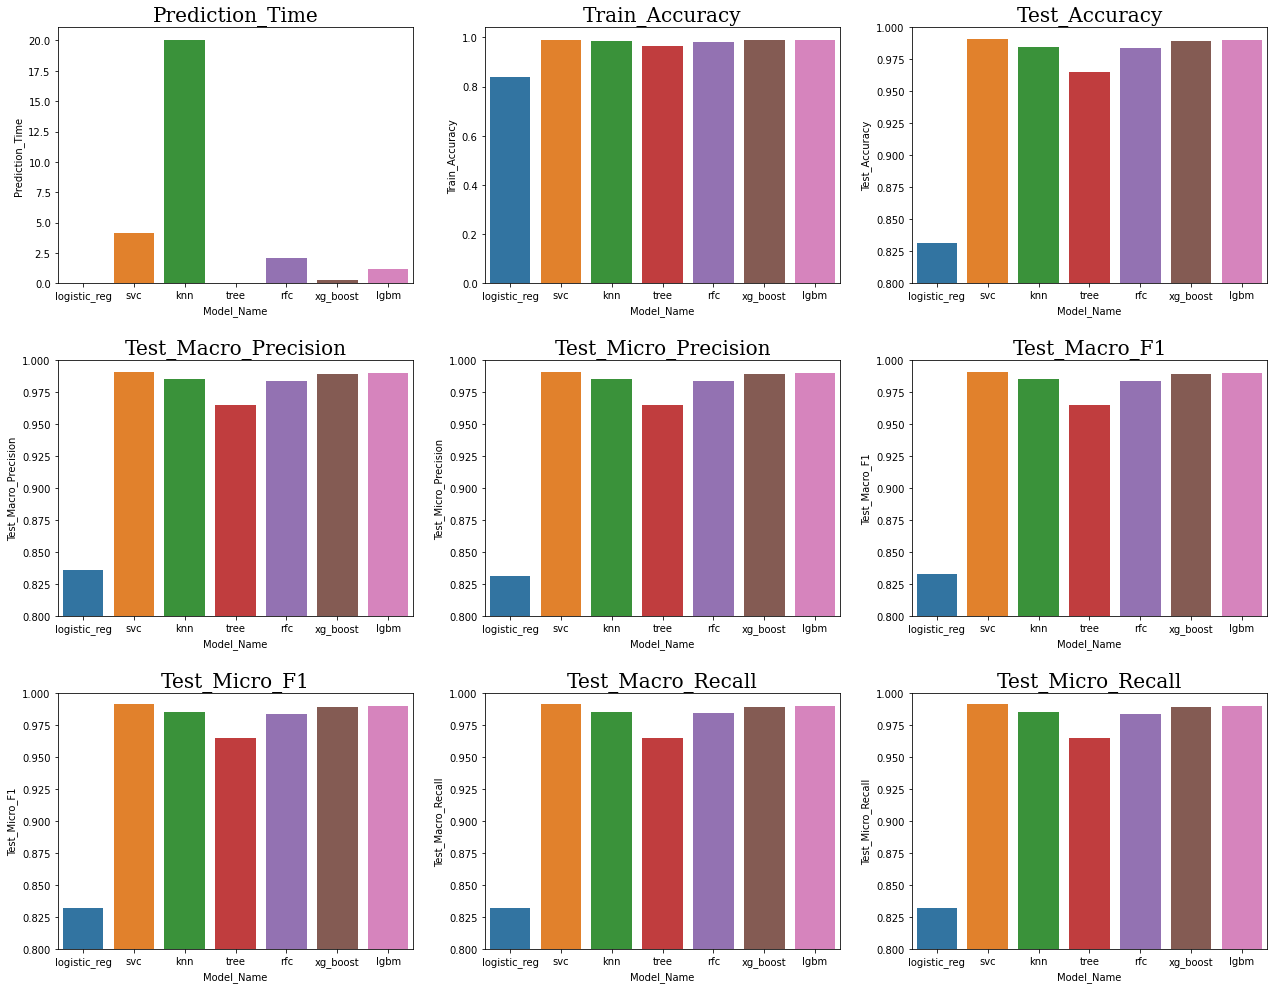

In [45]:
# Metrics for plotting
metrics_cols = ['Prediction_Time', 'Train_Accuracy', 'Test_Accuracy', 'Test_Macro_Precision', 'Test_Micro_Precision',
       'Test_Macro_F1', 'Test_Micro_F1', 'Test_Macro_Recall',
       'Test_Micro_Recall']


fig, axes = plt.subplots(3, 3)
fig.set_figheight(16)
fig.set_figwidth(21)
axarr = axes.flat
for idx, ax in enumerate(axarr):
    axis = sns.barplot(
        x = evaluation_df.index,
        y = evaluation_df[metrics_cols[idx]],
        ax = ax
    )
    axis.set_title(metrics_cols[idx], fontdict = {'family': 'Serif', 'fontsize': 20})
    if(idx > 1):
        axis.set_ylim(bottom = 0.8, top = 1.0)
plt.subplots_adjust(
left=0.1,
bottom = 0.1,
right=0.9,
top = 0.9,
wspace=0.2,
hspace = 0.3    
)
plt.savefig('Evaluation bar plots.jpeg')

## Observations from Evaluation
    -> Support Vector Classifier gives the best performance with XGBoost and LightGBM not too far behind.
    -> Logistic Regression shows poor performance in terms of metrics, while KNN takes too much time to make predictions.
    -> We shall consider prediction time, accuracy_score and F1_Score to decide best model for the classification.
    -> Considering evaluation metrics, SVC shall be chosen, being the best. But, with XGBoost having almost as high accuracy as SVC, and considerably lower time taken for predictions, XGBoost model shall be chosen as the final model for our web application.

# <center>Thank You </center>